In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [7]:
path = PureWindowsPath(os.getcwd() + "\\data\\input\\data.parquet")
path = path.as_posix()
corpus = pd.read_parquet(path) #engine="fastparquet"

zeros_subset = corpus.loc[corpus["category_bin"] == 0, :]
ones_subset = corpus.loc[corpus["category_bin"] == 1, :]
number_of_minority_class = len(zeros_subset)
sampled_ones = ones_subset.sample(number_of_minority_class, random_state=42)
print(sampled_ones.shape)
corpus = pd.concat([sampled_ones, zeros_subset], ignore_index=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.index = list(range(len(corpus)))
corpus["id"] = corpus.index	#creation de l'id seulement apres equilibrage des classes et melange aleatoire
print(corpus["category_bin"].value_counts())
print(corpus.id.duplicated().any()) #Verifier qu'il n'y a pas d'id en doublon
print(corpus.index.duplicated().any())

(1825, 6)
1    1825
0    1825
Name: category_bin, dtype: int64
False
False


In [5]:
from sklearn.svm import SVC

model = SVC()
X = corpus["message_preprocessed"]
y = corpus["category"]
y = corpus["category_bin"]
indices = corpus["id"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
print(indices_test)
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
model.fit(X_train_tfidf, y_train)

# test du modele
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = model.predict(X_test_tfidf)
print(y_pred)
print(X_test.shape)
print(X_test_tfidf.shape)

1313    1313
1674    1674
229      229
2974    2974
2222    2222
        ... 
1618    1618
819      819
100      100
3208    3208
3371    3371
Name: id, Length: 1205, dtype: int64
[0 0 0 ... 1 1 1]
(1205,)
(1205, 9482)


C:\Users\eupho\AppData\Local\Temp/ipykernel_6680/2510564835.py:19: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
C:\Users\eupho\AppData\Local\Temp/ipykernel_6680/2510564835.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)


Text(69.0, 0.5, 'Catégories réelles')

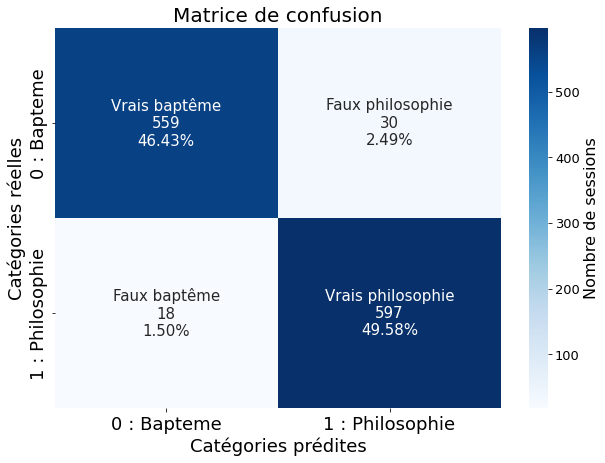

In [10]:
# Matrice de confusion
false_label = "0 : Bapteme"
true_label = "1 : Philosophie"
confusion_matrix_var = confusion_matrix(y_test, y_pred, labels=model.classes_)
group_names = ["Vrais baptême", "Faux philosophie", "Faux baptême", "Vrais philosophie"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix_var.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix_var.flatten()/np.sum(confusion_matrix_var)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
font_size = 15 #19
plt.rcParams["figure.figsize"] = (10, 7) #taille du graphique, taille du plot
ax = sb.heatmap(confusion_matrix_var, 
                annot=labels, fmt="", cmap='Blues',
                annot_kws={"size": font_size}, 
                cbar_kws={'label': 'Nombre de sessions'})
ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)
ax.figure.axes[-1].yaxis.label.set_size(font_size + 1)
ax.figure.axes[-1].tick_params(labelsize=font_size - 2) 
plt.title("Matrice de confusion", fontsize = font_size + 5)
# xlabel = 'Catégories prédites\n\n Exactitude (bien classés) = {:0.2f} % ; Inexactitude (mal classés) = {:0.2f} %\n Précision (bonnes prédictions de robots / qualité) = {:0.2f} %\n Rappel (nombre de robots détectés / quantité) = {:0.2f} %\n F1 (synthèse de précision + rappel) = {:0.2f} %'.format(accuracy, (100 - accuracy), precision, recall, f1_score)
plt.xlabel("Catégories prédites", fontsize=font_size + 3)
plt.ylabel("Catégories réelles", fontsize=font_size + 3)

In [11]:
# Metriques
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       589
           1       0.95      0.97      0.96       615

    accuracy                           0.96      1204
   macro avg       0.96      0.96      0.96      1204
weighted avg       0.96      0.96      0.96      1204



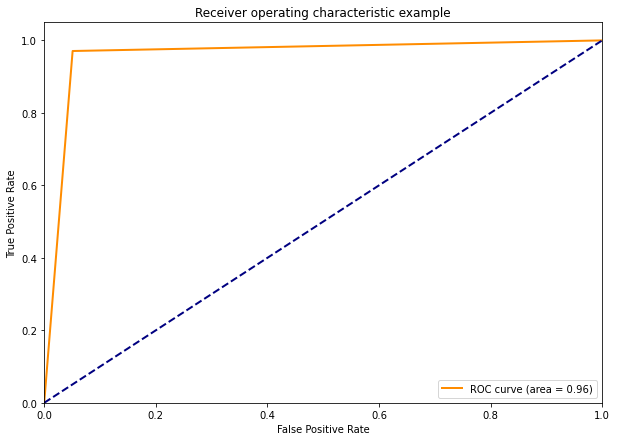

In [12]:
# Courbe ROC et AUC
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [13]:
# On affiche les documents a propos desquels le modele s'est trompe
corpus_test = pd.DataFrame({"id":corpus.iloc[indices_test].id, "message": corpus.iloc[indices_test].message, "truth":y_test, "pred":y_pred})
corpus_test_errors = corpus_test.query("truth != pred")
print(corpus_test.shape)
print(corpus_test_errors.shape)
# corpus_test_errors = corpus_test_errors[["truth", "pred", "message_preprocessed"]]
print(corpus_test_errors.columns)
corpus_test_errors = corpus_test_errors[["id", "truth", "pred", "message"]]
# corpus_test_errors

(1204, 4)
(48, 4)
Index(['id', 'message', 'truth', 'pred'], dtype='object')


In [14]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 1].id]) #aux philosophi

,id,message,message_preprocessed,category,length,category_bin
3113,3113,"Maxime est étudiant en médecine à Lille. Fondateur du blog Parlafoi.fr, il se passionne pour la théologie systématique, l'histoire du dogme et la philosophie réaliste. Vous entendrez souvent dans sa bouche ""Thomas d'Aquin"", ""Jean Calvin"" et ""Vive la scolastique"". Il affirme être marié à la meilleure épouse du monde. Ils vivent ensemble sur Lille avec leurs deux enfants et sont moniteurs de la méthode Billings.",maxime étudiant médecine lille fondateur blog parlafoifr passionne théologie systématique histoire dogme philosophie réaliste entendrez souvent bouche thomas aquin jean calvin vive scolastique affirme être marié meilleur épouse monde vivent ensemble lille leurs deux enfant moniteur méthode billings,baptism,413,0
196,196,Cet article est le premier d’une série de courts articles qui vise à donner des pistes de compréhension du langage baptismal chez les pères et les liturgies antiques.,cet article premier série court article vise donner piste compréhension langage baptismal chez père liturgie antique,baptism,166,0
1366,1366,"Historiquement, le dernier gros effort confessionnel a été l’établissement d’une sotériologie précise, et le dernier grand concile doctrinal a été le synode de Dordrecht, qui a établi les cinq points du calvinisme. On a donc l’impression que l’achèvement final de la théologie réformée est sa sotériologie, alors que ce n’est pas le plus important chez elle.",historiquement dernier gros effort confessionnel a établissement sotériologie précise dernier grand concile doctrinal a synode dordrecht a établi cinq point calvinisme a donc impression achèvement final théologie réformée sotériologie alors plus important chez,baptism,358,0
2429,2429,"4. Voir la page 221, Sources Chrétiennes, Éditions du Cerf[↩]",voir page source chrétien édition cerf↩,baptism,63,0
3489,3489,"=> « Incirconcis de cœur » ! Ça ne vous parles pas ? Cela montrent deux choses : – premièrement : Ils étaient circoncis mais pas de coeur. Cela veut dire qu’ils avaient un « esprit religieux », ils faisaient tout par tradition mais leurs cœurs n’étaient pas en Dieu. Alors cela déplu à Dieu. – deuxièmement : que Dieu n’a que faire des traditions et des religions, ce qu’Il attends de homme est un cœur entier, pur, qui aime Dieu et fasse Sa Volonté par L’Esprit-Saint !",« incirconcis cœur » ça parles cela montrent deux chose – premièrement circoncis coeur cela veut dire « esprit religieux » faisaient tout tradition leurs cœurs dieu alors cela déplu dieu – deuxièmement dieu a faire tradition religion attends homme cœur entier pur aime dieu fasse volonté esprit-saint,baptism,474,0
2501,2501,Alors nous avons une méthode différente qui explique nos conclusions différentes. Pour la systématique est exégèse : <https://calvinistinternational.com/2018/04/24/systematic-theology-as- exegesis/>,alors méthode différente explique conclusion différentes systématique exégèse httpscalvinistinternationalcomsystematic-theology-as- exegesis,baptism,200,0
3348,3348,Cela suffira à comprendre ce qu’est le point le plus important de la théologie réformée.,cela suffira comprendre point plus important théologie réformée,baptism,88,0
1053,1053,"Aucun d’eux n’a écrit: baptisez les enfants, pas une phrase ne va dans ce sens. Les choses évidentes sont toutes énoncées très clairement.",aucun a écrit baptisez enfant phrase va sens chose évidentes toutes énoncées très clairement,baptism,138,0
3398,3398,"Au lieu de chercher à justifier des actes, traditions déjà bien encrées en toi, cherchent plutôt la vérité en Dieu.",lieu chercher justifier acte tradition déjà bien encrées cherchent plutôt vérité dieu,baptism,115,0
1474,1474,Ce commentaire de James Packer est intéressant à deux égards :,commentaire james packer intéressant deux égard,baptism,62,0


In [15]:
with pd.option_context("display.max_rows", 1000):
    display(corpus.iloc[corpus_test_errors[corpus_test_errors["pred"] == 0].id]) #faux bapteme

#faux exemples a enlever : commentaires, description auteur, texte anglais, references bibliographiques

,id,message,message_preprocessed,category,length,category_bin
642,642,[Maxime N. Georgel](http://www.parlafoi.local) sur 10 janvier 2020 à 17 h 55 min,maxime georgelhttpwwwparlafoilocal janvier heure min,philosophy,80,1
1027,1027,"Sans commenter sur le créationnisme terre-jeune, je n’estime pas que tous les classicistes sont évidentialistes. En fait, ceux comme Wiliam Lane Craig le sont ouvertement, mais ceux qui sont réformés ne le sont, à mon avis, pas. En effet, en s’inscrivant dans la tradition réformée, nous faisons appel à la nature, mais pas en dehors des Écritures. Nous reconnaissons amplement que les arguments ne peuvent pas convertir l’homme naturel et difficilement briser ses fortifications. Et même « l’argument transcendantal peut être un argument utile dans la boîte à outils de l’apologiste, mais pas au prix de la dépréciation ou de la négligence du livre de la nature. » (FESKO, John, Reforming Apologetics, Baker Publishing Group, Édition du Kindle, p.7). Pareillement, une démarche utile dans la boîte à outils de tout apologiste est de remettre en question des présupposés. Mais la logique et la raison ne sont pas des présupposés, mais des points de départs que croyants et incroyants partagent en commun. Le croyant n’est pas plus immunisé que l’incroyant contre les fautes logiques, même si par la lumière de l’esprit dans son intellect, il a certainement un avantage.",sans commenter créationnisme terre-jeune estime tous classicistes évidentialistes fait ceux comme wiliam lane craig ouvertement ceux réformé avis effet inscrivant tradition réformée faisons appel nature dehors écriture reconnaissons amplement argument peuvent convertir homme naturel difficilement briser fortification « argument transcendantal peut être argument utile boîte outil apologiste prix dépréciation négligence livre nature » fesko john reforming apologetics baker publishing group édition kindle p pareillement démarche utile boîte outil tout apologiste remettre question présupposé logique raison présupposé point départ croyant incroyant partagent commun croyant plus immunisé incroyant contre faute logique si lumière esprit intellect a certainement avantage,philosophy,1171,1
544,544,Nous obtenons la perfection de la gloire « Nous avons l’assurance d’un libre accès au sanctuaire par le sang de Jésus » Hébreux 10.19,obtenons perfection gloire « assurance libre accès sanctuaire sang jésus » hébreux,philosophy,133,1
2339,2339,"> Tandis qu’il parlait ainsi, une femme éleva la voix du milieu de la foule et > lui dit : Heureux le ventre qui t’a porté et les seins qui t’ont allaité ! > Mais il répondit : Heureux plutôt ceux qui entendent la parole de Dieu et > qui l’observent ! > > Luc 11.27-28",tandis parlait ainsi femme éleva voix milieu foule dit heureux ventre a porté sein allaité répondit heureux plutôt ceux entendent parole dieu observent luc -,philosophy,271,1
3460,3460,"Il y a des idées comme celle-là qui sont stockées chez les pères, et qui sauvent votre vie spirituelle.",a idée comme celle-là stockées chez père sauvent vie spirituel,philosophy,103,1
442,442,"Pour ceux qui ne sont pas encore convaincus, je vous invite à voir directement la [question 9 dans l’original par eux- même](http://docteurangelique.free.fr/bibliotheque/sommes/1sommetheologique1apars.htm). Passons au second article de cette très courte section.",ceux encore convaincus invite voir directement question original eux- mêmehttpdocteurangeliquefreefrbibliothequesommessommetheologiqueaparshtm passons second article cette très courte section,philosophy,262,1
3396,3396,"Retenons ceci: John Frame, à mon avis, a été lourdement discrédité dans cette controverse, particulièrement par son insistance à critiquer la tradition historique de l’église. Le pire de ses arguments reste encore celui où il a critiqué James Dolezal pour sa remise en cause du consensus d’une douzaine de théologiens contemporains… alors que cette douzaine est en contradiction avec toute l’histoire de l’église, de Cl